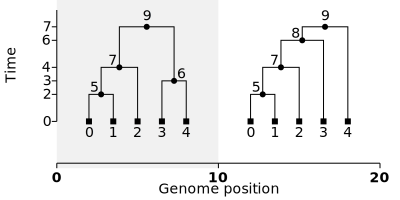

In [1]:
import io
import tskit

nodes = """\
is_sample time
1         0
1         0
1         0
1         0
1         0
0         2
0         3
0         4
0         6
0         7
"""

edges = """\
left   right   parent  child
0      20      5       0,1
0      10      6       3,4
0      20      7       5,2
0      10      9       7,6
10     20      8       7,3
10     20      9       8,4
"""

# nodes = """\
# is_sample time
# 1         0
# 1         0
# 1         0
# 1         0
# 0         4
# 0         5
# 0         6
# 0         7
# """
# edges = """\
# left   right   parent  child
# 0      2       4       0,1
# 0      2       5       2,3
# 0      1       6       4,5
# 1      2       7       4,5
# """

# sites = """\
# position ancestral_state
# """

# mutations = """\
# site node parent derived_state
# """

ts = tskit.load_text(
    nodes=io.StringIO(nodes),
    edges=io.StringIO(edges),
    # sites=io.StringIO(sites),
    # mutations=io.StringIO(mutations),
    strict=False,
)

ts.draw_svg(y_axis=True)

In [3]:
def get_weights(A, B):
    w_AB = A & B
    w_Ab = A - w_AB
    w_aB = B - w_AB
    return tuple(map(len, (w_AB, w_Ab, w_aB)))

In [226]:
from math import prod
def sample(val, n):
    """
    Perform ordered sampling without replacement
    """
    assert n > 0, "not valid for n < 1"
    vals = []
    while n:
        vals.append(val)
        val -= 1
        n -= 1
    return prod(vals)

def F_ijij(w_AB, w_Ab, w_aB, n):
    return (
        sample(w_AB, 2) / sample(n, 2)
    )

def F_ijik(w_AB, w_Ab, w_aB, n):
    return (
        (sample(w_AB, 3)) +
        (sample(w_AB, 2) * sample(w_Ab, 1)) +
        (sample(w_AB, 2) * sample(w_aB, 1)) +
        (sample(w_AB, 1) * sample(w_Ab, 1) * sample(w_aB, 1))
    ) / sample(n, 3)

def F_ijkl(w_AB, w_Ab, w_aB, n):
    return (
        (1 * (sample(w_AB, 4))) +
        (2 * (sample(w_AB, 3) * sample(w_Ab, 1))) +
        (2 * (sample(w_AB, 3) * sample(w_aB, 1))) +
        (1 * (sample(w_AB, 2) * sample(w_Ab, 2))) +
        (1 * (sample(w_AB, 2) * sample(w_aB, 2))) +
        (1 * (sample(w_Ab, 2) * sample(w_aB, 2))) +
        (4 * (sample(w_AB, 2) * sample(w_Ab, 1) * sample(w_aB, 1))) +
        (2 * (sample(w_AB, 1) * sample(w_Ab, 2) * sample(w_aB, 1))) +
        (2 * (sample(w_AB, 1) * sample(w_Ab, 1) * sample(w_aB, 2)))
    ) / sample(n, 4)

def D2(w_AB, w_Ab, w_aB, n):
    return F_ijij(w_AB, w_Ab, w_aB, n) - 2 * F_ijik(w_AB, w_Ab, w_aB, n) + F_ijkl(w_AB, w_Ab, w_aB, n)

def pi2(w_AB, w_Ab, w_aB, n):
    return F_ijkl(w_AB, w_Ab, w_aB, n)

def r2(w_AB, w_Ab, w_aB, n):
    p_AB = w_AB / float(n)
    p_Ab = w_Ab / float(n)
    p_aB = w_aB / float(n)

    p_A = p_AB + p_Ab
    p_B = p_AB + p_aB

    D_ = p_AB - (p_A * p_B)
    denom = p_A * p_B * (1 - p_A) * (1 - p_B)

    if denom == 0 and D_ == 0:
        return 0.0
        # return np.nan

    return (D_ * D_) / denom

In [200]:
from dataclasses import dataclass
from typing import get_type_hints

@dataclass
class TreeState:
    samples_under_nodes: list[set]
    parents: list[int]
    branch_len: list[float]
    nodes: list[int]

    tj: int = 0
    tk: int = 0
    t_left: int = 0
    t_right: int = 0
    tree_index: int = 0
    total_branch_len: int = 0

    def __init__(self, ts=None):
        if ts is not None:
            self.parents = [tskit.NULL] * ts.num_nodes
            self.nodes = [tskit.NULL] * ts.num_nodes
            self.samples_under_nodes = [set() for _ in range(ts.num_nodes)]
            self.branch_len = [0.0 for _ in range(ts.num_nodes)]
            for s in ts.samples():
                self.samples_under_nodes[s].add(s)

    def copy(self):
        new = TreeState()
        for attr, a_type in get_type_hints(self).items():
            if a_type == list[set]:
                setattr(new, attr, [v.copy() for v in getattr(self, attr)])
            elif a_type in {list[float], list[int]}:
                setattr(new, attr, getattr(self, attr).copy())
            elif a_type == int:
                setattr(new, attr, getattr(self, attr))
            else:
                raise ValueError(f"Unknown type encountered in copy: {a_type}")
        return new 

In [201]:
def compute_stat(ts, stat_func, stat, l_state=None, r_state=None):
    if l_state is None:
        l_state = TreeState(ts)
    if r_state is None:
        r_state = TreeState(ts)

    time = ts.tables.nodes.time
    edges_out = ts.indexes_edge_removal_order
    edges_in = ts.indexes_edge_insertion_order

    assert r_state.tj < ts.num_edges or r_state.t_left < ts.sequence_length, "out of bounds"
    while r_state.tk < ts.num_edges and ts.edges_right[edges_out[r_state.tk]] == r_state.t_left:
        e = edges_out[r_state.tk]
        r_state.tk += 1
        child = ts.edges_child[e]
        parent = ts.edges_parent[e]

        r_len = time[parent] - time[child]
        r_state.branch_len[child] = 0
        r_state.total_branch_len -= r_len
        r_state.nodes[child] = tskit.NULL

        for n, has in enumerate(l_state.nodes):
            if has != tskit.NULL:
                l_len = l_state.branch_len[n]
                weights = get_weights(l_state.samples_under_nodes[n], r_state.samples_under_nodes[child])
                stat -= stat_func(*weights, ts.num_samples) * l_len * r_len

        while parent != tskit.NULL:
            r_state.samples_under_nodes[parent] -= r_state.samples_under_nodes[child]
            parent = r_state.parents[parent]
        r_state.parents[child] = tskit.NULL

    while r_state.tj < ts.num_edges and ts.edges_left[edges_in[r_state.tj]] == r_state.t_left:
        e = edges_in[r_state.tj]
        r_state.tj += 1
        child = ts.edges_child[e]
        parent = ts.edges_parent[e]

        r_len = time[parent] - time[child]
        r_state.branch_len[child] = r_len
        r_state.total_branch_len += r_len
        r_state.nodes[child] = 1

        for n, has in enumerate(l_state.nodes):
            if has != tskit.NULL:
                l_len = l_state.branch_len[n]
                weights = get_weights(l_state.samples_under_nodes[n], r_state.samples_under_nodes[child])
                stat += stat_func(*weights, ts.num_samples) * l_len * r_len

        r_state.parents[child] = parent
        while parent != tskit.NULL:
            r_state.samples_under_nodes[parent] |= r_state.samples_under_nodes[child]
            parent = r_state.parents[parent]

    r_state.t_right = ts.sequence_length
    if r_state.tj < ts.num_edges:
        r_state.t_right = min(r_state.t_right, ts.edges_left[edges_in[r_state.tj]])
    if r_state.tk < ts.num_edges:
        r_state.t_right = min(r_state.t_right, ts.edges_right[edges_out[r_state.tk]])

    # set the lefthand bound
    r_state.t_left = r_state.t_right
    r_state.tree_index += 1
    return stat, r_state

In [214]:
l_state = None
stat = 0

stat, l_state = compute_stat(ts, D2, stat)
print(stat)
stat, r_state = compute_stat(ts, D2, stat, l_state, None)
print(stat, stat / (l_state.total_branch_len * r_state.total_branch_len))
stat, r_state = compute_stat(ts, D2, stat, l_state, r_state)
print(stat, stat / (l_state.total_branch_len * r_state.total_branch_len))

0
6.233333333333333 0.011783238815374922
2.3999999999999995 0.004013377926421403


In [227]:
l_state = None
stat = 0

stat, l_state = compute_stat(ts, pi2, stat)
print(stat)
stat, r_state = compute_stat(ts, pi2, stat, l_state, None)
print(stat, stat / (l_state.total_branch_len * r_state.total_branch_len))
stat, r_state = compute_stat(ts, pi2, stat, l_state, r_state)
print(stat, stat / (l_state.total_branch_len * r_state.total_branch_len))

0
2.9333333333333336 0.005545053560176434
1.8333333333333333 0.0030657748049052395


In [217]:
l_state.total_branch_len, r_state.total_branch_len

(23.0, 26.0)

In [218]:
l_state = None
stat = 0

stat, l_state = compute_stat(ts, r2, stat)
print(stat)
stat, r_state = compute_stat(ts, r2, stat, l_state, None)
print(stat, stat / (l_state.total_branch_len * r_state.total_branch_len))
stat, r_state = compute_stat(ts, r2, stat, l_state, r_state)
print(stat, stat / (l_state.total_branch_len * r_state.total_branch_len))

0
179.90277777777774 0.34008086536441917
175.7083333333333 0.29382664437012257


In [228]:
import msprime

In [ ]:
ts = msprime.

In [13]:
def gen_two_muts(ts, rate, lim=1000):
    while True:
        ts_new = msprime.sim_mutations(ts, rate=rate)
        lim -= 1
        if ts_new.at_index(0).num_mutations == 1 and ts_new.at_index(1).num_mutations == 1:
            return ts_new
        if not lim:
            raise Exception("Didn't gen a tree")

In [14]:
def gen_n_two_muts(ts, rate, n, print_rate=1000):
    out = []
    for i in range(n):
        out.append(gen_two_muts(ts, rate=rate))
        if not i % print_rate:
            print(i)
    return out

In [15]:
two_muts_trees = gen_n_two_muts(ts, .001, 100_000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [31]:
import numpy as np

In [32]:
np.mean([tskit.LdCalculator(ts).get_r2(0, 1) for ts in two_muts_trees])

0.2933854166666667